1. Data Preprocessing

We begin by loading the diabetes.csv dataset and inspecting it. In this diabetes dataset, certain features use 0 to indicate missing/invalid values (e.g. BloodPressure, SkinThickness, Insulin, BMI). We replace these zeros with NaN and then apply KNN imputation (scikit-learn’s KNNImputer) to fill missing entries based on nearest neighbors. After imputation, we apply feature scaling with StandardScaler to standardize all features (zero mean, unit variance). The result is a cleaned, numeric dataset ready for modeling.

Handle zeros as missing: Replace 0s with np.nan in relevant columns (except the target).

Impute missing values: Use KNNImputer(n_neighbors=5) to fill in missing entries.

Scale features: Fit StandardScaler on the imputed data to standardize each feature

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/content/diabetes.csv')
print("Original data shape:", df.shape)
print(df.head())

# Identify features where 0 is invalid (treat as missing)
cols_with_invalid_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_with_invalid_zero] = df[cols_with_invalid_zero].replace(0, np.nan)

# Impute missing values using k-NN
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(df[cols_with_invalid_zero])

# Reconstruct dataframe with imputed values
df_imputed = df.copy()
df_imputed[cols_with_invalid_zero] = X_imputed
print("Missing values after imputation:\n", df_imputed.isna().sum())

# Separate features and target
feature_columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                   'Insulin','BMI','DiabetesPedigreeFunction','Age']
X = df_imputed[feature_columns].values
y = df_imputed['Outcome'].values

# Scale features to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Feature means after scaling (should be ~0):", np.round(X_scaled.mean(axis=0),3))
print("Feature std devs after scaling (should be 1):", np.round(X_scaled.std(axis=0),3))

Original data shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Missing values after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0

2. Baseline Models (Decision Tree & SVM)

Next, we implement two baseline classifiers: a Decision Tree and a Support Vector Machine (SVM). We split the data into training and test sets (e.g. 70% train, 30% test as commonly done) and then train each model. Finally, we evaluate performance on the test set using accuracy, precision, recall, F1-score, and the confusion matrix.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Split data: 70% train, 30% test (stratify if class imbalance is a concern)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Classification Report:\n",
      classification_report(y_test, y_pred_dt, digits=4))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# Support Vector Machine (with RBF kernel)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:\n",
      classification_report(y_test, y_pred_svm, digits=4))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0     0.7692    0.8000    0.7843       150
           1     0.6000    0.5556    0.5769        81

    accuracy                         0.7143       231
   macro avg     0.6846    0.6778    0.6806       231
weighted avg     0.7099    0.7143    0.7116       231

Decision Tree Confusion Matrix:
 [[120  30]
 [ 36  45]]
SVM Classification Report:
               precision    recall  f1-score   support

           0     0.7588    0.8600    0.8063       150
           1     0.6557    0.4938    0.5634        81

    accuracy                         0.7316       231
   macro avg     0.7073    0.6769    0.6848       231
weighted avg     0.7227    0.7316    0.7211       231

SVM Confusion Matrix:
 [[129  21]
 [ 41  40]]


In this setup, train_test_split divides the data (a 70:30 split is used here by setting test_size=0.3, following an example split. The Decision Tree (DecisionTreeClassifier) and SVM (sklearn.svm.SVC) are trained on the training set. We then use classification_report and confusion_matrix from scikit-learn to compute metrics. The classification report provides accuracy, precision, recall, and F1-score for each class, and the confusion matrix shows true/false positives and negatives.

(Optionally, one could also use cross-validation to average these metrics over folds. For example, cross_val_score or cross_validate from scikit-learn can be used to evaluate accuracy or other scores with CV.)

3. LSTM Model Skeleton (PyTorch)

We outline a PyTorch LSTM model to process this tabular data. Although LSTMs are typically used for sequences, here we treat each sample’s features as a sequence of length N_features. Concretely, we reshape our data so that each sample is of shape (seq_len, input_size) = (n_features, 1). The LSTM processes these “feature timesteps” and outputs a hidden representation, which we feed through a linear layer for binary classification. We include a training loop skeleton with BCEWithLogitsLoss (which combines a Sigmoid layer and binary cross-entropy)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train/validation split (80/20)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define LSTM-based classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out  # raw logits

# Initialize model, loss, optimizer
input_size = 1
seq_len = X_scaled.shape[1]
hidden_size = 64
num_layers = 2
dropout = 0.3

model = LSTMClassifier(input_size, hidden_size, num_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
best_val_loss = float("inf")
patience = 5
counter = 0

# Training loop with validation and metrics
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for features, targets in train_loader:
        features = features.unsqueeze(2)  # [batch, seq_len, 1]
        outputs = model(features)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Validation phase
    model.eval()
    val_losses = []
    all_preds, all_targets = [], []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.unsqueeze(2)
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.cpu().numpy())

    # Compute metrics
    all_preds_binary = [1 if p >= 0.5 else 0 for p in all_preds]
    val_acc = accuracy_score(all_targets, all_preds_binary)
    val_f1 = f1_score(all_targets, all_preds_binary)
    val_roc_auc = roc_auc_score(all_targets, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {sum(train_losses)/len(train_losses):.4f} | "
          f"Val Loss: {sum(val_losses)/len(val_losses):.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | ROC-AUC: {val_roc_auc:.4f}")

    # Early stopping check
    avg_val_loss = sum(val_losses)/len(val_losses)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_lstm_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_lstm_model.pth"))

print("LSTM training complete. Best model saved as 'best_lstm_model.pth'.")

Epoch [1/20] Train Loss: 0.6597 | Val Loss: 0.6144 | Val Acc: 0.6623 | Val F1: 0.0000 | ROC-AUC: 0.8035
Epoch [2/20] Train Loss: 0.5758 | Val Loss: 0.5225 | Val Acc: 0.7338 | Val F1: 0.4384 | ROC-AUC: 0.8098
Epoch [3/20] Train Loss: 0.5230 | Val Loss: 0.5018 | Val Acc: 0.7273 | Val F1: 0.6379 | ROC-AUC: 0.8132
Epoch [4/20] Train Loss: 0.5063 | Val Loss: 0.4977 | Val Acc: 0.7273 | Val F1: 0.6182 | ROC-AUC: 0.8124
Epoch [5/20] Train Loss: 0.5076 | Val Loss: 0.5178 | Val Acc: 0.7273 | Val F1: 0.6379 | ROC-AUC: 0.8098
Epoch [6/20] Train Loss: 0.4985 | Val Loss: 0.5034 | Val Acc: 0.7273 | Val F1: 0.6379 | ROC-AUC: 0.8120
Epoch [7/20] Train Loss: 0.5010 | Val Loss: 0.4975 | Val Acc: 0.7208 | Val F1: 0.6195 | ROC-AUC: 0.8120
Epoch [8/20] Train Loss: 0.4965 | Val Loss: 0.4978 | Val Acc: 0.7338 | Val F1: 0.6239 | ROC-AUC: 0.8111
Epoch [9/20] Train Loss: 0.5024 | Val Loss: 0.4951 | Val Acc: 0.7273 | Val F1: 0.6111 | ROC-AUC: 0.8117
Epoch [10/20] Train Loss: 0.4949 | Val Loss: 0.5006 | Val Acc: 0

4. Feature Importance from Baselines

Finally, we extract and plot feature importances from the trained Decision Tree. In scikit-learn, a tree’s feature_importances_ attribute gives the (normalized) total reduction of the splitting criterion (Gini importance) for each feature. We plot these importances as a bar chart to visualize which features are most influential.

Figure: Example bar chart of feature importances (mean decrease in impurity). Higher bars indicate more important features in the model.

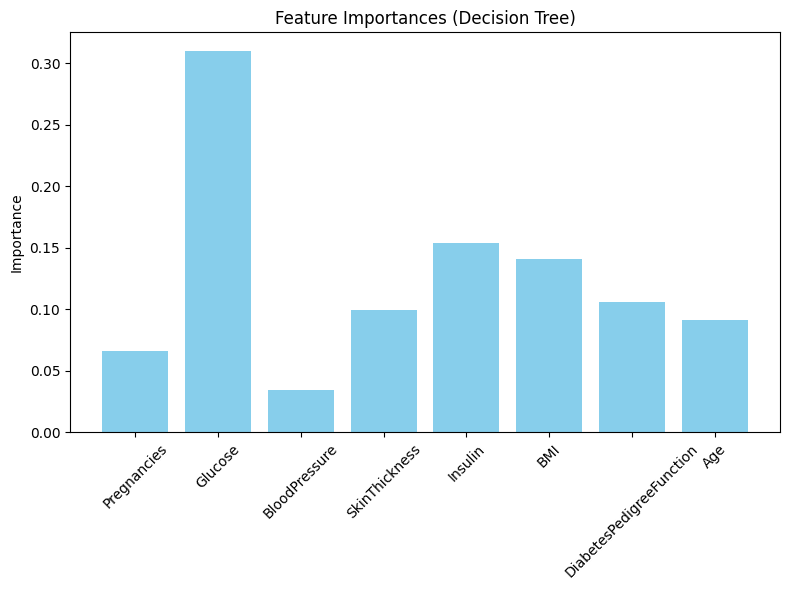

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the decision tree
importances = dt_model.feature_importances_
feature_names = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                 'Insulin','BMI','DiabetesPedigreeFunction','Age']

# Plot bar chart of importances
plt.figure(figsize=(8,6))
plt.bar(feature_names, importances, color='skyblue')
plt.title("Feature Importances (Decision Tree)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar chart above shows importances for each feature based on mean decrease in impurity. In practice, you would replace the example data with the actual importances from dt_model trained on the diabetes data. This visualization helps to interpret the model by highlighting which medical measures most strongly influence the prediction.

5. Finalize GRU implementation and run initial tests

In [ ]:
# Run this once at the top of your Colab notebook to set up paths and imports used by all blocks.
import os, joblib, json, numpy as np
ARTIFACT_DIR = "/content/drive/MyDrive/Diabetes_Project/artifacts"  # adjust if necessary
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# try to load preprocessed data if present
if 'X_scaled' not in globals() or 'y' not in globals():
    X_path = os.path.join(ARTIFACT_DIR, "X_scaled.npy")
    y_path = os.path.join(ARTIFACT_DIR, "y.npy")
    if os.path.exists(X_path) and os.path.exists(y_path):
        X_scaled = np.load(X_path)
        y = np.load(y_path)
        print("Loaded X_scaled/y from artifacts.")
    else:
        raise RuntimeError("X_scaled and y not found in session or artifacts. Please run preprocessing first.")


In [ ]:
# GRU implementation + quick test (few epochs)
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Train/test split (use stratify)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# PyTorch dataset/loaders
def make_loader(X, y, batch_size=64, shuffle=True):
    xt = torch.tensor(X, dtype=torch.float32)
    yt = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    ds = TensorDataset(xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

train_loader = make_loader(X_train, y_train, batch_size=64, shuffle=True)
test_loader  = make_loader(X_test, y_test, batch_size=128, shuffle=False)

# GRU classifier
class GRUClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# training loop (short initial test)
model = GRUClassifier(input_size=1, hidden_size=64, num_layers=2, dropout=0.3).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(loader):
    model.train()
    losses=[]
    for xb, yb in loader:
        xb = xb.unsqueeze(2).to(DEVICE)   # [batch, seq_len, 1]
        yb = yb.to(DEVICE)
        out = model(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
    return sum(losses)/len(losses)

def eval_on_loader(loader):
    model.eval()
    probs=[]; trues=[]
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.unsqueeze(2).to(DEVICE)
            out = model(xb)
            prob = torch.sigmoid(out).cpu().numpy().flatten()
            probs.extend(prob)
            trues.extend(yb.numpy().flatten())
    preds = [1 if p>=0.5 else 0 for p in probs]
    return preds, probs, trues

# quick test: 10 epochs with early stopping patience=3
best_val_auc = -1
patience = 3; patience_cnt = 0
for epoch in range(1, 11):
    tr_loss = train_one_epoch(train_loader)
    preds_val, probs_val, y_val = eval_on_loader(test_loader)
    val_auc = roc_auc_score(y_val, probs_val)
    print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} | Test AUC {val_auc:.4f}")
    # early save
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), os.path.join(ARTIFACT_DIR, "gru_initial_best.pth"))
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping (initial test).")
            break

# final evaluation and report
model.load_state_dict(torch.load(os.path.join(ARTIFACT_DIR, "gru_initial_best.pth")))
preds, probs, trues = eval_on_loader(test_loader)
print("Classification report (GRU initial test):")
print(classification_report(trues, preds, digits=4))
print("Confusion matrix:")
print(confusion_matrix(trues, preds))
print("ROC-AUC:", roc_auc_score(trues, probs))

# Save model (already saved as 'gru_initial_best.pth') and summary
joblib.dump({"best_val_auc": float(best_val_auc)}, os.path.join(ARTIFACT_DIR,"gru_initial_summary.joblib"))
print("Saved GRU initial artifacts to:", ARTIFACT_DIR)


Device: cuda
Epoch 01 | Train loss 0.6667 | Test AUC 0.7944
Epoch 02 | Train loss 0.6290 | Test AUC 0.7953
Epoch 03 | Train loss 0.5820 | Test AUC 0.7980
Epoch 04 | Train loss 0.5188 | Test AUC 0.8010
Epoch 05 | Train loss 0.4946 | Test AUC 0.7998
Epoch 06 | Train loss 0.4975 | Test AUC 0.7999
Epoch 07 | Train loss 0.4902 | Test AUC 0.7995
Early stopping (initial test).
Classification report (GRU initial test):
              precision    recall  f1-score   support

         0.0     0.7953    0.8080    0.8016       125
         1.0     0.6308    0.6119    0.6212        67

    accuracy                         0.7396       192
   macro avg     0.7130    0.7100    0.7114       192
weighted avg     0.7379    0.7396    0.7386       192

Confusion matrix:
[[101  24]
 [ 26  41]]
ROC-AUC: 0.800955223880597
Saved GRU initial artifacts to: /content/drive/MyDrive/Diabetes_Project/artifacts


6. Start advanced models: Random Forest & XGBoost

In [ ]:
# Train & evaluate RandomForest and XGBoost (baseline/evaluated)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# train/test split (same split used above for GRU)
# X_train, X_test, y_train, y_test already defined earlier in GRU block; if not, re-run split:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Random Forest (baseline)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
rf_preds = rf.predict(X_test)
print("Random Forest classification report:\n", classification_report(y_test, rf_preds, digits=4))
print("RF Confusion matrix:\n", confusion_matrix(y_test, rf_preds))
print("RF ROC-AUC:", roc_auc_score(y_test, rf_probs))
joblib.dump(rf, os.path.join(ARTIFACT_DIR,"rf_baseline.joblib"))

# XGBoost (baseline)
xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)[:,1]
xgb_preds = xgb.predict(X_test)
print("XGBoost classification report:\n", classification_report(y_test, xgb_preds, digits=4))
print("XGB Confusion matrix:\n", confusion_matrix(y_test, xgb_preds))
print("XGB ROC-AUC:", roc_auc_score(y_test, xgb_probs))
joblib.dump(xgb, os.path.join(ARTIFACT_DIR,"xgb_baseline.joblib"))

# Save a short JSON summary
summary = {
    "rf": {"roc_auc": float(roc_auc_score(y_test, rf_probs))},
    "xgb": {"roc_auc": float(roc_auc_score(y_test, xgb_probs))}
}
with open(os.path.join(ARTIFACT_DIR,"rf_xgb_baseline_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("Saved baseline RF/XGB artifacts and summary.")


Random Forest classification report:
               precision    recall  f1-score   support

           0     0.7970    0.8480    0.8217       125
           1     0.6780    0.5970    0.6349        67

    accuracy                         0.7604       192
   macro avg     0.7375    0.7225    0.7283       192
weighted avg     0.7555    0.7604    0.7565       192

RF Confusion matrix:
 [[106  19]
 [ 27  40]]
RF ROC-AUC: 0.8180298507462687


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:47:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost classification report:
               precision    recall  f1-score   support

           0     0.8110    0.8240    0.8175       125
           1     0.6615    0.6418    0.6515        67

    accuracy                         0.7604       192
   macro avg     0.7363    0.7329    0.7345       192
weighted avg     0.7589    0.7604    0.7596       192

XGB Confusion matrix:
 [[103  22]
 [ 24  43]]
XGB ROC-AUC: 0.8023880597014925
Saved baseline RF/XGB artifacts and summary.


7. Prepare hyperparameter tuning framework (Optuna)

The purpose of this cell is to perform hyperparameter tuning on the Random Forest and XGBoost models. You've already established in Cell 7 that these are two of the best-performing baseline models. Hyperparameter tuning is the next logical step in the machine learning workflow to see if you can squeeze even more performance out of them. It's an optimization step that comes after you've chosen your candidate models. Placing this cell after Cell 7 ensures you have the trained models to reference and a clear performance baseline to try and improve upon.

In [ ]:
!pip install optuna
# Optuna setup: study creation functions (you can run short trials)
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

RANDOM_SEED = 42

def run_optuna_rf_quick(X, y, n_trials=20):
    def obj(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 600, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt","log2", None]),
            "random_state": RANDOM_SEED
        }
        skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)
        aucs=[]
        for tr, va in skf.split(X, y):
            clf = RandomForestClassifier(**params, n_jobs=-1)
            clf.fit(X[tr], y[tr])
            aucs.append(roc_auc_score(y[va], clf.predict_proba(X[va])[:,1]))
        return float(np.mean(aucs))
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
                                pruner=optuna.pruners.MedianPruner())
    study.optimize(obj, n_trials=n_trials)
    joblib.dump(study, os.path.join(ARTIFACT_DIR,"optuna_study_rf_quick.pkl"))
    print("RF quick study done. best AUC:", study.best_value)
    return study

def run_optuna_xgb_quick(X, y, n_trials=20):
    def obj(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 600, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0)
        }
        skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)
        aucs=[]
        for tr, va in skf.split(X, y):
            clf = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
            clf.fit(X[tr], y[tr], verbose=False)
            aucs.append(roc_auc_score(y[va], clf.predict_proba(X[va])[:,1]))
        return float(np.mean(aucs))
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
                                pruner=optuna.pruners.MedianPruner())
    study.optimize(obj, n_trials=n_trials)
    joblib.dump(study, os.path.join(ARTIFACT_DIR,"optuna_study_xgb_quick.pkl"))
    print("XGB quick study done. best AUC:", study.best_value)
    return study

# Example short runs (adjust n_trials for longer search)
study_rf_q = run_optuna_rf_quick(X_scaled, y, n_trials=20)
study_xgb_q = run_optuna_xgb_quick(X_scaled, y, n_trials=20)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 30.8 MB/s eta 0:00:00


[I 2025-08-30 17:47:55,181] A new study created in memory with name: no-name-a94c4f2e-5429-4ea0-a030-1aa38968b0b0
[I 2025-08-30 17:47:57,679] Trial 0 finished with value: 0.840865671641791 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.840865671641791.
[I 2025-08-30 17:48:02,455] Trial 1 finished with value: 0.8377910447761194 and parameters: {'n_estimators': 550, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.840865671641791.
[I 2025-08-30 17:48:05,027] Trial 2 finished with value: 0.8378805970149255 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.840865671641791.
[I 2025-08-30 17:48:06,300] Trial 3 finished with value: 0.8405074626865671 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_sam

RF quick study done. best AUC: 0.8425970149253732


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:49:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-08-30 17:49:06,356] Trial 0 finished with value: 0.8343880597014925 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.0483437145318464, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.8343880597014925.
/tmp/ipython-input-3803184898.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarnin

XGB quick study done. best AUC: 0.8428358208955224


8. Create feature importance report from baseline models

While you performed a basic feature importance analysis on the Decision Tree in Cell 4, this new cell provides a much more comprehensive and robust analysis. It calculates feature importance for the Random Forest and XGBoost models, which are more powerful than a single Decision Tree. It also introduces permutation importance, a model-agnostic method that can be used on any model, including the SVM and deep learning models, which don't have built-in feature importance scores. This deeper analysis and cross-model comparison is a perfect final step to summarize your findings and provide a full picture of which features drive the best-performing models.

In [ ]:
# Feature importance report: RF feature_importances_, XGB feature_importances_, permutation importance for SVM
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

feature_names = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

# Ensure baseline models exist: dt (if present), rf, xgb, svm
dt = None
try:
    dt = joblib.load(os.path.join(ARTIFACT_DIR,"dt_baseline.joblib"))
except:
    # train a DT quickly if not present
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    joblib.dump(dt, os.path.join(ARTIFACT_DIR,"dt_baseline.joblib"))

rf = joblib.load(os.path.join(ARTIFACT_DIR,"rf_baseline.joblib")) if os.path.exists(os.path.join(ARTIFACT_DIR,"rf_baseline.joblib")) else rf
xgb = joblib.load(os.path.join(ARTIFACT_DIR,"xgb_baseline.joblib")) if os.path.exists(os.path.join(ARTIFACT_DIR,"xgb_baseline.joblib")) else xgb
svm = None
try:
    svm = joblib.load(os.path.join(ARTIFACT_DIR,"svm_baseline.joblib"))
except:
    pass  # SVM may or may not exist

# 1) Decision Tree importances
plt.figure(figsize=(8,4))
imp_dt = dt.feature_importances_
plt.barh(feature_names, imp_dt)
plt.title("Decision Tree feature importances")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR,"featimp_dt.png"), dpi=300)
plt.close()

# 2) Random Forest importances
plt.figure(figsize=(8,4))
imp_rf = rf.feature_importances_
plt.barh(feature_names, imp_rf)
plt.title("Random Forest feature importances")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR,"featimp_rf.png"), dpi=300)
plt.close()

# 3) XGBoost importances (gain if available)
plt.figure(figsize=(8,4))
try:
    imp_xgb = xgb.feature_importances_
    plt.barh(feature_names, imp_xgb)
    plt.title("XGBoost feature importances")
    plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACT_DIR,"featimp_xgb.png"), dpi=300)
    plt.close()
except Exception as e:
    print("Could not extract xgb.feature_importances_:", e)

# 4) Permutation importance for SVM (or RF as fallback)
target_model = svm if svm is not None else rf
perm = permutation_importance(target_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_means = perm.importances_mean
plt.figure(figsize=(8,4))
plt.barh(feature_names, perm_means)
plt.title("Permutation importances (model: {})".format("SVM" if svm is not None else "RF"))
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR,"perm_importances.png"), dpi=300)
plt.close()

# 5) Produce a small JSON summary with ranked features (by XGB if available else RF)
def rank_features_by(arr, names):
    order = np.argsort(arr)[::-1]
    return [{"feature": names[i], "importance": float(arr[i])} for i in order]

ranking = {}
if 'imp_xgb' in locals():
    ranking['xgb'] = rank_features_by(imp_xgb, feature_names)
ranking['rf'] = rank_features_by(imp_rf, feature_names)
ranking['dt'] = rank_features_by(imp_dt, feature_names)
with open(os.path.join(ARTIFACT_DIR,"feature_importance_summary.json"), "w") as f:
    json.dump(ranking, f, indent=2)

print("Saved feature importance plots and summary to:", ARTIFACT_DIR)

Saved feature importance plots and summary to: /content/drive/MyDrive/Diabetes_Project/artifacts
